In [1]:
import os
os.chdir("../..")
os.getcwd() 

'/Users/arthurphan/Desktop/MAPIE'

In [2]:
import warnings

import datetime
import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

from mapie.subsample import BlockBootstrap
from mapie.time_series_regression import MapieTimeSeriesRegressor

%reload_ext autoreload
%autoreload 2
warnings.simplefilter("ignore")

In [3]:
#########################################################
# Global random forests parameters
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = 6

model = RandomForestRegressor(
        n_estimators=n_estimators,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=1)

In [4]:
data = pd.read_csv("Prices_2016_2019_extract.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'Prices_2016_2019_extract.csv'

In [ ]:
data.head()

,Date,Spot,hour,dow_0,dow_1,dow_2,dow_3,dow_4,dow_5,dow_6,...,lag_168_15,lag_168_16,lag_168_17,lag_168_18,lag_168_19,lag_168_20,lag_168_21,lag_168_22,lag_168_23,conso
0,2016-01-08 00:00:00,24.36,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,62700.0
1,2016-01-08 01:00:00,19.33,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,60700.0
2,2016-01-08 02:00:00,16.10,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,59200.0
3,2016-01-08 03:00:00,15.00,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,56400.0
4,2016-01-08 04:00:00,15.00,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,20.06,19.43,24.57,33.11,35.34,33.07,29.52,30.1,24.57,55300.0


In [ ]:
data.shape

(34896, 59)

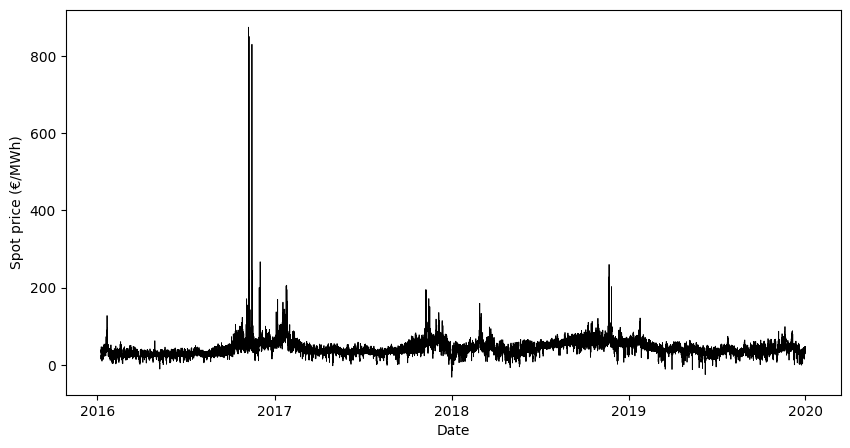

In [ ]:
date_plot = pd.to_datetime(data.Date)

plt_1 = plt.figure(figsize=(10, 5))
plt.plot(date_plot, data.Spot, color='black', linewidth=0.6)
locs, labels = plt.xticks()
plt.xticks(locs[0:len(locs):2], labels=['2016','2017','2018','2019','2020'])
plt.xlabel('Date')
plt.ylabel('Spot price (\u20AC/MWh)')
plt.show()

In [ ]:
limit = datetime.datetime(2019, 1, 1, tzinfo=datetime.timezone.utc)
id_train = data.index[pd.to_datetime(data['Date'], utc=True) < limit].tolist()
id_test = data.index[pd.to_datetime(data['Date'], utc=True) >= limit].tolist()

data_train = data.iloc[id_train,:]
data_test = data.iloc[id_test,:]

In [ ]:
X_train = data_train.loc[:,['hour','dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6'] + 
                       ['lag_24_%d'%i for i in range(24)] +
                       ['lag_168_%d'%i for i in range(24)] + ['conso']]
y_train = data_train.Spot

X_train_0 = X_train.loc[X_train.hour == 0]
y_train_0 = data_train.loc[data_train.hour == 0, 'Spot']

X_test = data_test.loc[:,['hour','dow_0','dow_1','dow_2','dow_3','dow_4','dow_5','dow_6'] + 
                       ['lag_24_%d'%i for i in range(24)] +
                       ['lag_168_%d'%i for i in range(24)] + ['conso']]

y_test = data_test.Spot

X_test_0 = X_test.loc[X_test.hour == 0]
y_test_0 = data_test.loc[data_test.hour == 0, 'Spot']

In [ ]:
alpha = 0.1
gap = 1
tab_gamma = [0,
             0.000005,
             0.00005,
             0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0008,0.0009,
             0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
             0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09]

mapie_aci = MapieTimeSeriesRegressor(
    model, method="aci", agg_function="mean", n_jobs=-1
)


In [ ]:
import pickle

path_to_pickle_file = '/Users/arthurphan/Desktop/MAPIE/notebooks/regression/results/Spot_France_Hour_0_train_2019-01-01/ACP_0.04_RF.pkl'

try:
    with open(path_to_pickle_file, 'rb') as file:
        loaded_data = pickle.load(file)

except FileNotFoundError:
    print(f"The file {path_to_pickle_file} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")
    
path_to_csv_files = '/Users/arthurphan/Desktop/MAPIE/notebooks/regression/results_csv/Spot_France_Hour_0_train_2019-01-01'

data_dict = {}

for filename in os.listdir(path_to_csv_files):
    if filename.endswith('.csv') and 'ACP' in filename:
        file_path = os.path.join(path_to_csv_files, filename)  
        df = pd.read_csv(file_path)  
        data_dict[filename] = df
        
bounds = data_dict["ACP_0.04_RF.pkl.csv"][["Y_inf","Y_sup"]]
y_pred_MZ = (bounds["Y_inf"]+bounds["Y_sup"])/2


In [ ]:
from tqdm.autonotebook import tqdm
import numpy as np
all_x_train = [np.array(data_train.loc[data_train.hour == h]) for h in range(24)]

train_size = all_x_train[0].shape[0]
idx = np.array(range(train_size))
n_half = int(np.floor(train_size/2))

X_train_0 = X_train_0[:n_half]
y_train_0 = y_train_0[:n_half]

mapie_aci = mapie_aci.fit(X_train_0, y_train_0)
y_pred_aci_npfit, y_pis_aci_npfit = mapie_aci.predict(
    X_test_0, alpha=alpha, ensemble=True, optimize_beta=False
)

y_pred_aci_pfit = np.zeros(y_pred_aci_npfit.shape)
y_pis_aci_pfit = np.zeros(y_pis_aci_npfit.shape)
y_pred_aci_pfit[:gap], y_pis_aci_pfit[:gap, :, :] = mapie_aci.predict(
    X_test_0.iloc[:gap, :], alpha=alpha, ensemble=True, optimize_beta=False
)

results_dict = {}

#for gamma in tab_gamma:
for step in tqdm(range(1, len(X_test_0), gap)):

    mapie_aci.estimator_.single_estimator_.fit(X_test_0.iloc[(step - gap):step, :],
                                               y_test_0.iloc[(step - gap):step])

    mapie_aci.partial_fit(
        X_test.iloc[(step - gap):step, :],
        y_test.iloc[(step - gap):step],
    )

    mapie_aci.adapt_conformal_inference(
        X_test_0.iloc[(step - gap):step, :],
        y_test_0.iloc[(step - gap):step],
        gamma = 0.04
    )
    (
        y_pred_aci_pfit[step:step + gap],
        y_pis_aci_pfit[step:step + gap, :, :],
    ) = mapie_aci.predict(
        X_test_0.iloc[step:(step + gap), :],
        alpha=alpha,
        ensemble=True,
        optimize_beta=True
    )
    results_dict[f"ACP_0.04"] = y_pis_aci_pfit.copy()

  0%|          | 0/364 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(results_dict["ACP_0.04"].reshape(-1, 2),columns=["Y_inf","Y_sup"])

,Y_inf,Y_sup
0,43.289121,50.643991
1,40.035052,48.670751
2,43.819559,54.233296
3,50.396704,60.383079
4,54.199752,64.130023
...,...,...
360,9.958045,43.327828
361,16.121521,49.409692
362,13.880930,46.855419
363,13.922121,46.529305


In [ ]:
# Extract the array from the dictionary
array_to_compare = results_dict["ACP_0.04"]

# Flatten the array to shape (n, 2)
flattened_array = array_to_compare.reshape(-1, 2)

# Convert the flattened array to a NumPy array
array_np = np.array(flattened_array)

# Compare the NumPy array with the corresponding DataFrame columns
comparison_result_Y_inf = np.array_equal(array_np[:, 0], df['Y_inf'])
comparison_result_Y_sup = np.array_equal(array_np[:, 1], df['Y_sup'])

# Print the comparison results
print(f"Comparison for ACP_0.04 (Y_inf): {comparison_result_Y_inf}")
print(f"Comparison for ACP_0.04 (Y_sup): {comparison_result_Y_sup}")

Comparison for ACP_0.04 (Y_inf): True
Comparison for ACP_0.04 (Y_sup): True
